In [9]:
import pandas as pd 
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [26]:
df = pd.read_csv("profilGT20.csv",sep=";")
df

,distance,altitude
0,0,"9,5"
1,85,"9,3"
2,171,9
3,193,"8,8"
4,208,"8,5"
...,...,...
15946,593055,"12,2"
15947,593070,"11,3"
15948,593092,"10,5"
15949,593106,"10,2"


In [27]:
#df = df.rename(columns={"0": "distance", "9.5": "altitude"})
df['altitude'] = pd.to_numeric(df['altitude'].str.replace(',', '.'), errors='coerce')
df["slope"] = (df["altitude"].diff()/df['distance'].diff()).shift(-1)
df

,distance,altitude,slope
0,0,9.5,-0.002353
1,85,9.3,-0.003488
2,171,9.0,-0.009091
3,193,8.8,-0.020000
4,208,8.5,-0.037500
...,...,...,...
15946,593055,12.2,-0.060000
15947,593070,11.3,-0.036364
15948,593092,10.5,-0.021429
15949,593106,10.2,-0.013333


## Data

In [28]:
g    = 9.81
rho  = 1.23
Crr  = 0.0025
CdA  = 0.33
loss = 0.02
wind = 0
M    = 72
m    = 8

plotOption = False

In [29]:
def get_gravity(slope,M):
    return (M+m)*g*np.sin(np.arctan(slope))

def get_rolling(slope,Crr):
    return (M+m)*g*np.cos(np.arctan(slope))*Crr

def get_aero(slope,CdA,v,wind):
    return 0.5*CdA*rho*((v+wind)/3.6)**2



In [30]:
def get_P_from_v(v, slope, M, Crr, CdA, wind, loss):
    gravity = get_gravity(slope,M)
    rolling = get_rolling(slope,Crr)
    aero    = get_aero(slope,CdA,v,wind)
    forces  = gravity + rolling + aero
    
    if plotOption == True:
        print('Gravity Power = ', np.round(gravity*v/3.6,2))
        print('Rolling Power = ', np.round(rolling*v/3.6,2))
        print('Aero Power = ', np.round(aero*v/3.6,2))

    return forces*v/3.6*(1/(1-loss))

def get_P_ratio_from_v(v, slope, M, Crr, CdA, wind, loss):
    forces =(gravity(slope,M) + rolling(slope,Crr) + aero(slope,CdA,v,wind))
    return forces*v/3.6*(1/(1-loss))/M

In [31]:
get_P_from_v(30,0.05,M,Crr, CdA, wind, loss)

469.7648287963007

# Simulation of the Speed

In [32]:
def get_poly_function(x_array,y_array,degree):
    coefficients = np.polyfit(slope_array, speed_array, degree)
    poly_function = np.poly1d(coefficients)
    return poly_function

In [33]:
slope_array = [-0.1,0,0.05,0.1,0.15,0.34]
speed_array = [50,34,21,16,9,6]
degree = 2

In [34]:
#slope_array = [-0.1,0,0.05,0.1,0.15,0.34]
#speed_array = [50,34,23,17,10,5]

slope_array = [-0.1,0,0.05,0.1,0.15,0.20,.34]
speed_array = [50,34,21,16,9,8,5]

degree = 2

In [35]:
def from_slope_get_v(slope):
    poly_function = get_poly_function(slope_array,speed_array,degree)
    if slope < -0.1:
        v = 50
    else:
        v = poly_function(slope)
    return v


In [37]:
def message_utilisateur():
    # Demande à l'utilisateur de saisir son nom
    nom_utilisateur = input("Veuillez saisir votre nom : ")

    # Affiche un message de salutation avec le nom de l'utilisateur
    message = f"Bonjour, {nom_utilisateur} ! Bienvenue dans notre programme."
    print(message)

# Appelle la fonction pour exécuter le code
message_utilisateur()


Veuillez saisir votre nom : Marin
Bonjour, Marin ! Bienvenue dans notre programme.


In [39]:
slopes = np.arange(-0.2,0.34,0.01)
speed = [from_slope_get_v(slope) for slope in slopes]

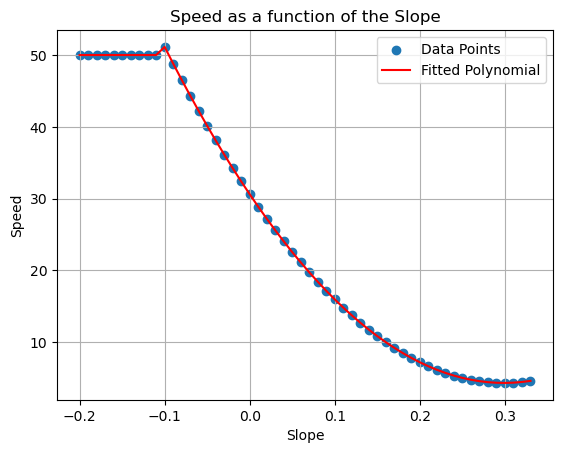

In [40]:
import matplotlib.pyplot as plt

plt.scatter(slopes, speed, label='Data Points')
plt.plot(slopes, speed, label='Fitted Polynomial', color='red')
plt.legend()
plt.grid()
plt.xlabel('Slope')
plt.ylabel('Speed')
plt.title('Speed as a function of the Slope')
plt.show()

In [41]:
df.head()

,distance,altitude,slope
0,0,9.5,-0.002353
1,85,9.3,-0.003488
2,171,9.0,-0.009091
3,193,8.8,-0.020000
4,208,8.5,-0.037500


## Get the Average Power

In [42]:
df['Speed']  = df['slope'].apply(from_slope_get_v)
df['dist'] = df['distance'].diff().shift(-1)
df['deltaT'] = (df['dist']*3.6)/df['Speed']
df['Power']  = df.apply(lambda x: get_P_from_v(x.Speed,x.slope,M,Crr, CdA, wind, loss), axis = 1)
df['Power']  = np.maximum(0,df['Power'])
df['Energy'] = df['deltaT']*df['Power']

In [43]:
avg_power = (df.Power*df.deltaT).sum()/df.deltaT.sum()
tot_time  = df.deltaT.sum()
print('Avg_Watts = ',avg_power)
print('Tot_time = ',tot_time/3600)

Avg_Watts =  175.56012697808615
Tot_time =  20.346821676556473


#### Get the Power as function of Slope

<Axes: xlabel='approx_slope'>

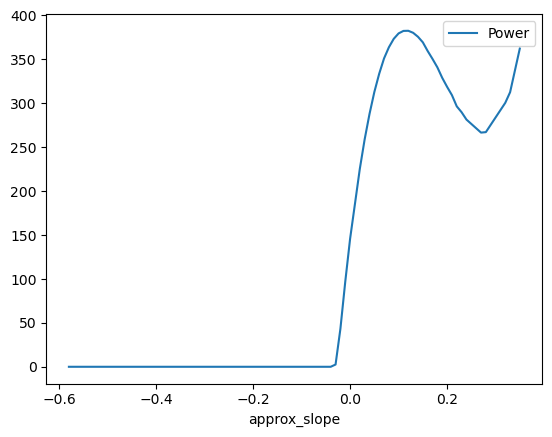

In [44]:
df['approx_slope'] = np.round(df['slope'],2)
reduced_df = df[['approx_slope','Power']].groupby('approx_slope').mean()
reduced_df.plot()

## Analysis of the extreme slopes

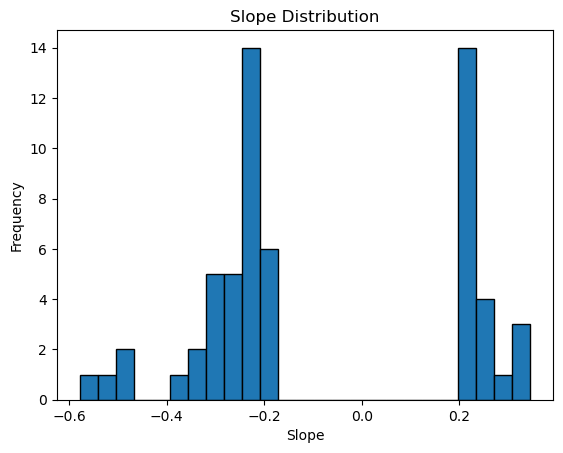

In [45]:
df.loc[np.abs(df['slope'])>0.2]['slope'].plot(kind='hist', bins=25, edgecolor='k')
plt.xlabel('Slope')
plt.ylabel('Frequency')
plt.title('Slope Distribution')
plt.show()

In [46]:
df.loc[np.abs(df['slope'])>0.2].head()

,distance,altitude,slope,Speed,dist,deltaT,Power,Energy,approx_slope
1375,48452,341.2,-0.258333,50.000000,12.0,0.864000,0.000000,0.000000,-0.26
1388,49017,309.6,-0.200000,50.000000,11.0,0.792000,0.000000,0.000000,-0.20
1481,52012,170.2,-0.260000,50.000000,10.0,0.720000,0.000000,0.000000,-0.26
1674,57561,104.1,0.209091,6.673995,11.0,5.933477,308.802808,1832.274444,0.21
1734,59265,183.8,0.209091,6.673995,11.0,5.933477,308.802808,1832.274444,0.21


## Get normalized Power

In [47]:
def get_normalized_power(df, column = 'Power'):
    return (np.mean(df[column].rolling(3).mean()**4))**(1/4)

In [48]:
get_normalized_power(df)

241.13453419886142

# Optimization of the Energy

In [49]:
df.head()

,distance,altitude,slope,Speed,dist,deltaT,Power,Energy,approx_slope
0,0,9.5,-0.002353,31.007454,85.0,9.868595,133.342978,1315.907806,-0.00
1,85,9.3,-0.003488,31.209185,86.0,9.920157,128.066524,1270.439975,-0.00
2,171,9.0,-0.009091,32.215693,22.0,2.458429,101.177410,248.737498,-0.01
3,193,8.8,-0.020000,34.228568,15.0,1.577630,44.780395,70.646875,-0.02
4,208,8.5,-0.037500,37.603924,16.0,1.531755,0.000000,0.000000,-0.04


# Step 1 : Simplify the profile

In [50]:
opti_df = df[['slope','dist','Energy']].copy()
opti_df['approx_slope'] = np.round(opti_df['slope'],2)
opti_df = opti_df[['approx_slope','dist','Energy']].groupby('approx_slope').sum()
opti_df

,dist,Energy
approx_slope,,
-0.58,23.0,0.000000
-0.54,25.0,0.000000
-0.50,27.0,0.000000
-0.48,12.0,0.000000
-0.37,13.0,0.000000
...,...,...
0.27,10.0,2110.088756
0.28,10.0,2181.624491
0.32,11.0,2695.325894


In [51]:
distances = opti_df['dist']
energies  = opti_df['Energy']
slopes    = opti_df.index

T_lim     = 20*3600
N         = len(distances)

In [52]:
def from_energy_to_time(energy,slope,d):
    numerator   = M+m+rho*CdA*d
    denominator = (1-loss)*energy - (M+m)*g*d*(np.sin(slope)+Crr*np.cos(slope))
    deltaT = d/np.sqrt(2) * (numerator/denominator)**0.5
    return deltaT

In [53]:
# Define the objective function to minimize (sum of variables x)
def objective_function(x):
    return np.sum(x)

# Define the constraint function g(x) and its sum
def constraint_function(x):
    times = [from_energy_to_time(x_val,slope,d) for x_val,slope,d in zip(x,slopes,distances)]
    return np.sum(times)

# Define the inequality constraint (sum of g(x) must be less than A)
def inequality_constraint(x):
    return T_lim - constraint_function(x)



# Set up the optimization problem with the inequality constraint
constraints = [{'type': 'ineq', 'fun': inequality_constraint}]

# Solve the optimization problem
result = minimize(objective_function, energies, constraints=constraints, method='SLSQP')

# Extract the optimized variables x
optimized_x = result.x

# Print the results
print("Optimized Variables (x):", optimized_x)
print("Optimal Objective Value:", result.fun)

Optimized Variables (x): [      0.               0.               0.               0.
       0.               0.               0.               0.
       0.               0.               0.               0.
       0.               0.               0.               0.
       0.               0.               0.               0.
       0.               0.               0.               0.
       0.               0.               0.               0.
       0.               0.               0.               0.
       0.               0.           14409.30518524  237632.95110087
  516613.84938266 1359922.80231851 1335436.93785568 1433583.35975009
 1533357.71306286 1475918.40084776 1206865.09395425  946069.83271291
  728878.00143018  536396.25767104  387773.87264145  319182.7170556
  242736.06796158  155535.30482769  118869.74617062   78943.6236221
   64961.11352184   38354.38816867   29607.50986024   24327.01360053
   16200.77037032    9910.05625119   13625.15193793    7538.14885268
    70

/var/folders/b5/2zd3m6xj67g_xrc_3g6294wh0000gn/T/ipykernel_25586/2408303615.py:4: RuntimeWarning: invalid value encountered in scalar power
  deltaT = d/np.sqrt(2) * (numerator/denominator)**0.5


In [54]:
result.fun/T_lim

178.6045298568365

In [55]:
opti_energy = optimized_x
opti_time = [from_energy_to_time(energy,slope,d) for energy,slope,d in zip(opti_energy,slopes,distances)]
opti_power = [energy/time for energy,time in zip(opti_energy,opti_time)]

/var/folders/b5/2zd3m6xj67g_xrc_3g6294wh0000gn/T/ipykernel_25586/2408303615.py:4: RuntimeWarning: invalid value encountered in scalar power
  deltaT = d/np.sqrt(2) * (numerator/denominator)**0.5


opti_Power    0.1
dtype: float64 352.8027772746801
20.227568200563347


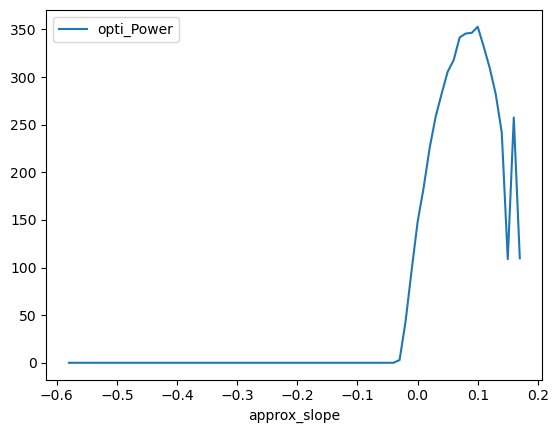

In [56]:
opti_df['opti_Energy'] = opti_energy
opti_df['opti_Time'] = opti_time
opti_df['opti_Power'] = opti_power
opti_df[['opti_Power']].plot()
print(opti_df[['opti_Power']].idxmax(),opti_df.opti_Power.max())
print(opti_df['opti_Time'].sum()/3600)